In [49]:
import numpy as np 
import pandas as pd 
import orca 

from sklearn.model_selection import KFold, train_test_split
from statsmodels.discrete.discrete_model import MNLogit

In [55]:
hdf = pd.HDFStore('output/pipeline.h5')
pp = hdf['/persons/trip_mode_choice']
hh = hdf['/households/trip_mode_choice']
tours = hdf['/tours/trip_mode_choice']
trips = hdf['/trips/trip_mode_choice']
acc = hdf['/accessibility/trip_mode_choice']
lu = hdf['/land_use/trip_mode_choice']

print ('Number of Households: ',hh.shape[0])
print ('Number of Persons: ',pp.shape[0])
print ('Number of tours: ',tours.shape[0])
print ('Number of trips: ',trips.shape[0])

Number of Households:  10000
Number of Persons:  24932
Number of tours:  31487
Number of trips:  80350


In [274]:
def simulation(probs):
    rands = np.random.rand(len(probs),1,)
    probs_arr = probs.values.cumsum(axis=1) - rands
    choices = np.argmax(probs_arr > 0.0, axis=1)
    choices = pd.Series(choices, index=probs.index)
    return choices

In [56]:
# Need to merge land use and accessibilities here 

In [57]:
hh_merge = hh.merge(acc, how = 'inner', left_on = 'TAZ', right_index = True).\
              merge(lu, how = 'inner', left_on = 'TAZ', right_index = True)

In [58]:
hh_merge.columns

Index(['serialno', 'hhsize', 'VEHICL', 'income', 'race_of_head', 'age_of_head',
       'num_workers', 'children', 'tenure', 'recent_mover', 'block_id', 'TAZ',
       'HHT', 'chunk_id', 'income_in_thousands', 'income_segment',
       'median_value_of_time', 'hh_value_of_time', 'num_non_workers',
       'num_drivers', 'num_adults', 'num_children', 'num_young_children',
       'num_children_5_to_15', 'num_children_16_to_17', 'num_college_age',
       'num_young_adults', 'non_family', 'family', 'home_is_urban',
       'home_is_rural', 'auto_ownership', 'hh_work_auto_savings_ratio',
       'num_under16_not_at_school', 'num_travel_active',
       'num_travel_active_adults', 'num_travel_active_preschoolers',
       'num_travel_active_children', 'num_travel_active_non_preschoolers',
       'participates_in_jtf_model', 'joint_tour_frequency',
       'num_hh_joint_tours', 'auPkRetail', 'auPkTotal', 'auOpRetail',
       'auOpTotal', 'trPkRetail', 'trPkTotal', 'trOpRetail', 'trOpTotal',
       'nm

In [59]:
#Car ownership - Dependent varible
hh_merge['cars'] = hh_merge.VEHICL.where(hh_merge.VEHICL < 4, 4)

In [60]:
#Household-based variables 
hh_merge['num_drivers_2'] = hh_merge.num_drivers == 2
hh_merge['num_drivers_3'] = hh_merge.num_drivers == 3
hh_merge['num_drivers_4+'] = hh_merge.num_drivers > 3
hh_merge['children_0_4'] = hh_merge.num_young_children > 0
hh_merge['children_5_17'] = (hh_merge.num_children_5_to_15 + hh_merge.num_children_16_to_17)>0
hh_merge['num_workes_3'] = hh_merge.num_workers.clip(upper = 3)
hh_merge['income_30'] = hh_merge.income_in_thousands.clip(0,30)
hh_merge['income_75'] = (hh_merge.income_in_thousands-30).clip(0,45)
hh_merge['income_125'] = (hh_merge.income_in_thousands-75).clip(0,50)

In [61]:
#Household and land_use-based variables 
hh_merge['density_10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index.clip(0,10))
hh_merge['density_+10_0w'] = (hh_merge.num_workers == 0)*(hh_merge.density_index-10).clip(0)
hh_merge['density_10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index.clip(0,10))
hh_merge['density_+10_+1w'] = (hh_merge.num_workers > 0)*(hh_merge.density_index-10).clip(0)
hh_merge['constant'] = 1

In [172]:
#Accessibility_based variables
hh_merge['retail_0w_auto'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
hh_merge['retail_+1w_auto'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.auPkRetail + 0.34*hh_merge.auOpRetail)
hh_merge['retail_0w_transit'] = (hh_merge.num_workers == 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
hh_merge['retail_+1w_transit'] = (hh_merge.num_workers > 0)*(0.66*hh_merge.trPkRetail + 0.34*hh_merge.trOpRetail)
hh_merge['retail_0w_nm'] = (hh_merge.num_workers == 0)*hh_merge.nmRetail
hh_merge['retail_+1w_nm'] = (hh_merge.num_workers > 0)*hh_merge.nmRetail
hh_merge['auto_saving_work'] = np.where(hh_merge.num_workers > 0, 
                                  hh_merge.hh_work_auto_savings_ratio/hh_merge.num_workers, 
                                  0)

In [177]:
variables = ['constant',
             'num_drivers_2', 'num_drivers_3', 'num_drivers_4+', 'num_children_16_to_17',
             'num_college_age', 'num_young_adults', 'children_0_4', 'children_5_17',
             'num_workes_3', 'income_30', 'income_75', 'income_125', 'density_10_0w',
#              'density_+10_0w', 
             'density_10_+1w', 
#              'density_+10_+1w',
             'retail_0w_auto','retail_+1w_auto', 
#              'retail_0w_transit','retail_+1w_transit', 
             'retail_0w_nm', 
             'retail_+1w_nm',
#              'auto_saving_work', 
             'cars'
            ]

# Train and test set

In [294]:
#Splitting the data
df = hh_merge[variables].astype(float)
x = df.drop(['cars'], axis = 1)
y = df.loc[:,'cars']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

## Multinomial Model 

In [183]:
model = MNLogit(y_train, X_train)
result = model.fit()
result.summary().add_table_params

Optimization terminated successfully.
         Current function value: 0.902357
         Iterations 8


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:                   cars   No. Observations:                 6700
Model:                        MNLogit   Df Residuals:                     6624
Method:                           MLE   Df Model:                           72
Date:                Thu, 28 May 2020   Pseudo R-squ.:                  0.2815
Time:                        00:16:41   Log-Likelihood:                -6045.8
converged:                       True   LL-Null:                       -8414.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
               cars=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
constant                  3.0662      1.035      2.961      0.003       1.037       5.096
num_driv

In [291]:
probs = result.predict(X_test)
choices = simulation(probs)

#Cross tab
cross_tab = pd.crosstab( y_test, choices).round(decimals=3)
accuracy = np.sum(np.diagonal(np.array(cross_tab)))/y_train.shape[0]
print('accuracy: ',accuracy*100)
cross_tab

accuracy:  25.11940298507463


col_0,0,1,2,3,4
cars,,,,,
0.0,13,58,24,8,2
1.0,66,678,326,69,22
2.0,35,322,842,189,64
3.0,4,48,194,124,46
4.0,2,16,71,51,26


In [292]:
print (choices.sum())
print (choices.value_counts())

5999
2    1457
1    1122
3     441
4     160
0     120
dtype: int64


In [293]:
print (y_test.sum())
print (y_test.value_counts())

5977.0
2.0    1452
1.0    1161
3.0     416
4.0     166
0.0     105
Name: cars, dtype: int64


# Machine learning approach 

In [307]:
variables = ['hhsize','income', 'race_of_head', 'age_of_head',
       'num_workers', 'children', 'tenure', 'recent_mover', 
       'HHT', 'income_in_thousands', 'income_segment',
       'median_value_of_time', 'hh_value_of_time', 'num_non_workers',
       'num_drivers', 'num_adults', 'num_children', 'num_young_children',
       'num_children_5_to_15', 'num_children_16_to_17', 'num_college_age',
       'num_young_adults', 'non_family', 'family', 'home_is_urban',
       'home_is_rural', 'hh_work_auto_savings_ratio',
       'num_under16_not_at_school', 'num_travel_active',
       'num_travel_active_adults', 'num_travel_active_preschoolers',
       'num_travel_active_children', 'num_travel_active_non_preschoolers',
       'auPkRetail', 'auPkTotal', 'auOpRetail',
       'auOpTotal', 'trPkRetail', 'trPkTotal', 'trOpRetail', 'trOpTotal',
       'nmRetail', 'nmTotal', 'TOTHH', 'HHPOP',
       'EMPRES', 'HHINCQ1', 'HHINCQ2', 'HHINCQ3', 'HHINCQ4', 'AGE0004',
       'AGE0519', 'AGE2044', 'AGE4564', 'AGE65P', 'AGE62P', 'SHPOP62P',
       'TOTEMP', 'RETEMPN', 'FPSEMPN', 'HEREMPN', 'AGREMPN', 'MWTEMPN',
       'OTHEMPN', 'TOTACRE', 'RESACRE', 'CIACRE', 'HSENROLL', 'TOPOLOGY',
       'employment_density', 'pop_density', 'hh_density', 'hq1_density',
       'PRKCST', 'OPRKCST', 'COLLFTE', 'COLLPTE', 'area_type', 'household_density', 'density_index', 'cars']

In [339]:
variables = ['hhsize','income', 'race_of_head', 'age_of_head',
       'num_workers', 'children', 'tenure', 'recent_mover', 
       'HHT', 'income_in_thousands', 'income_segment',
       'median_value_of_time', 'hh_value_of_time', 'num_non_workers',
       'num_drivers', 'num_adults', 'num_children', 'num_young_children',
       'num_children_5_to_15', 'cars','auPkRetail', 'auPkTotal', 'auOpRetail',
       'auOpTotal', 'trPkRetail', 'trPkTotal', 'trOpRetail', 'trOpTotal']

In [340]:
#Splitting the data
df = hh_merge[variables].astype(float)
x = df.drop(['cars'], axis = 1)
y = df.loc[:,'cars']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [341]:
from sklearn.ensemble import GradientBoostingClassifier

In [342]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)
importances = model.feature_importances_
pd.crosstab( y_test, model.predict(X_test))
model.score(X_test, y_test)

0.6575757575757576

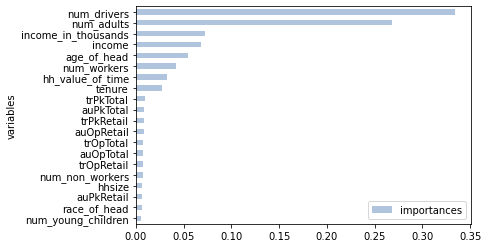

In [344]:
bb = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

bb[-20:].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
# plt.yticks();#(fontsize = 10)

In [345]:
pd.crosstab( y_test, model.predict(X_test))

col_0,0.0,1.0,2.0,3.0,4.0
cars,,,,,
0.0,18,68,18,0,1
1.0,24,849,258,25,5
2.0,5,227,1125,82,13
3.0,0,22,224,144,26
4.0,1,7,68,56,34


In [372]:
model.predict(X_test).sum()

5796.0

In [349]:
probs = model.predict_proba(X_test)

In [353]:
probs = pd.DataFrame(probs)

In [369]:
choices = simulation(probs)

#Cross tab
cross_tab = pd.crosstab(pd.Series(y_test.values), pd.Series(choices.values))
accuracy = np.sum(np.diagonal(np.array(cross_tab)))/y_test.shape[0]
print('accuracy: ',accuracy*100)
cross_tab

accuracy:  53.81818181818182


col_0,0,1,2,3,4
row_0,,,,,
0.0,26,55,18,6,0
1.0,55,716,304,59,27
2.0,27,302,873,198,52
3.0,7,50,182,129,48
4.0,1,15,64,54,32


In [370]:
print (choices.sum())
print (choices.value_counts())

5994
2    1441
1    1138
3     446
4     159
0     116
dtype: int64


In [371]:
print (y_test.sum())
print (y_test.value_counts())

5977.0
2.0    1452
1.0    1161
3.0     416
4.0     166
0.0     105
Name: cars, dtype: int64
